In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import seaborn as sns
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from scipy import stats

# Extraccion de datos

In [71]:
def extract_num(string):
    if isinstance(string, str):
        return float(string.split('(')[1].split(')')[0])
    elif isinstance(string, float):
        return string
    else:
        return None

def calculate_jaccard (Interaction):
    lst = Interaction.split('&')
    puntos = 0
    parentesis_abiertos = 0
    parentesis_cerrados = 0

    for cadena in lst:
        puntos += cadena.count('.')
        parentesis_abiertos += cadena.count('(')
        parentesis_cerrados += cadena.count(')')
        
    j = (parentesis_abiertos + parentesis_cerrados) / (parentesis_abiertos + parentesis_cerrados + puntos)
    #j = (parentesis_abiertos) / (parentesis_abiertos + puntos/2)
    return j



def clean_df(df):
    
    lst_conserved =[]; lst_miRNA = []; lst_prediction = []
    for i in range(len(df[0])-2):
        header = df[0][i]; miRNA = df[0][i+1]; prediction = df[0][i+2]
        
        if prediction.startswith('.') or prediction.startswith('('):
            bool_prediction = True
        else:
            bool_prediction = False
            
        if header.startswith('>') and miRNA.startswith('>hsa') and bool_prediction == True:
            lst_conserved.append(header); lst_miRNA.append(miRNA); lst_prediction.append(prediction)

    df = pd.DataFrame({
        'UTR_region': lst_conserved,
        'miRNA':lst_miRNA, 
        'Prediction':lst_prediction})

    df['Prediction'] = df['Prediction'].str.replace('( ', '(', regex=False)
    df['Prediction'] = df['Prediction'].str.replace('< ', '<', regex=False)
    df_e = df['Prediction'].apply(lambda x: x.split()).apply(pd.Series)
    df = pd.concat([df, df_e], axis = 1)
    
    df.drop([2], axis=1, inplace = True)
    df.columns = ['UTR_region', 'miRNA', 'Prediction', 'Interaction', 'InteractionRegionUTR', 
              'InteractionRegionmiRNA', 'DuplexEnergy', 'InteractionResidues', 'MinimumEnergy']
    
    df['DuplexEnergy'] = list(map(extract_num, df['DuplexEnergy']))
    df = df.sort_values(by=['DuplexEnergy'])

    df['Jaccard'] = list(map(calculate_jaccard, df['Interaction']))
    
    UTR3 = 29674
    UTR5 = 265

    lst_type = []
    for i in df['UTR_region']: 
        start,end = i.split(':')[1].split('-')
        if int(end) <= UTR5:
            lst_type.append("5'UTR")
        else:
            lst_type.append("3'UTR")
    df['Region'] = lst_type

    lst = []
    for i in df['UTR_region']:
        lst.append(i.split(':')[0].split('>')[1])
    df['Variant'] = lst
    return df

In [72]:
dfv = pd.read_csv('../Data/FastaPredict/conserved_SinFold_regions_UTR_variants_predicted_miRNA.txt', sep = '\t', header = None)
dfv = clean_df(dfv)
dfv

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant
683,>Global:31-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"59,83","1,25",-34.5,"i:82,j:1",<-34.60>,0.84,5'UTR,Global
489129,>21A:26-192,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"64,88","1,25",-34.5,"i:87,j:1",<-34.60>,0.84,5'UTR,21A
948388,>21L:45-218,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,21L
101550,>20A:29-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"61,85","1,25",-34.5,"i:84,j:1",<-34.60>,0.84,5'UTR,20A
1471405,>23F:45-185,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,23F
...,...,...,...,...,...,...,...,...,...,...,...,...
40943,>19A:17-20,>hsa-miR-3162-3p,".(.&.) 1,3 : 20,21 (4.30) i:2,j:21 <3.80>",.(.&.),"1,3","20,21",4.3,"i:2,j:21",<3.80>,0.40,5'UTR,19A
109954,>20A:200-203,>hsa-miR-3162-3p,".(.&.) 1,3 : 20,21 (4.30) i:3,j:21 <3.80>",.(.&.),"1,3","20,21",4.3,"i:3,j:21",<3.80>,0.40,5'UTR,20A
486909,>21A:16-20,>hsa-miR-3162-3p,".(.&.) 2,4 : 20,21 (4.30) i:3,j:21 <3.80>",.(.&.),"2,4","20,21",4.3,"i:3,j:21",<3.80>,0.40,5'UTR,21A
372777,>20H:17-20,>hsa-miR-3162-3p,".(.&.) 1,3 : 20,21 (4.30) i:2,j:21 <3.80>",.(.&.),"1,3","20,21",4.3,"i:2,j:21",<3.80>,0.40,5'UTR,20H


In [73]:
dft = pd.read_csv('../Data/FastaPredict/conserved_SinFold_regions_UTR_time_predicted_miRNA.txt', sep = '\t', header = None)
dft = clean_df(dft)
dft

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant
337855,">(2022-11-01,2023-01-01]:45-209",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2022-11-01,2023-01-01]"
266174,">(2022-01-01,2022-06-01]:45-209",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2022-01-01,2022-06-01]"
406880,">(2023-07-01,2023-09-06]:45-202",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2023-07-01,2023-09-06]"
300687,">(2022-06-01,2022-11-01]:45-202",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2022-06-01,2022-11-01]"
218397,">(2021-05-01,2022-01-01]:26-173",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"64,88","1,25",-34.5,"i:87,j:1",<-34.60>,0.84,5'UTR,"(2021-05-01,2022-01-01]"
...,...,...,...,...,...,...,...,...,...,...,...,...
36743,>Global:29888-29887,>hsa-miR-6781-5p,".(.&.) 1,3 : 20,21 (4.00) i:16,j:21 <3.60>",.(.&.),"1,3","20,21",4.0,"i:16,j:21",<3.60>,0.40,3'UTR,Global
328779,">(2022-06-01,2022-11-01]:29871-29903",>hsa-miR-6781-5p,".(.&.) 1,3 : 20,21 (4.00) i:32,j:21 <3.60>",.(.&.),"1,3","20,21",4.0,"i:32,j:21",<3.60>,0.40,3'UTR,"(2022-06-01,2022-11-01]"
448252,">(2023-07-01,2023-09-06]:29871-29903",>hsa-miR-6781-5p,".(.&.) 1,3 : 20,21 (4.00) i:32,j:21 <3.60>",.(.&.),"1,3","20,21",4.0,"i:32,j:21",<3.60>,0.40,3'UTR,"(2023-07-01,2023-09-06]"
36535,>Global:29888-29887,>hsa-miR-5703,".(.&.) 1,3 : 17,18 (4.00) i:16,j:18 <3.60>",.(.&.),"1,3","17,18",4.0,"i:16,j:18",<3.60>,0.40,3'UTR,Global


In [74]:
dft.to_csv('../Data/miRNA_conserved_Time_SinFiltrar.tsv', sep = '\t', index = False)
dfv.to_csv('../Data/miRNA_conservedSinEstructuraSecundaria_Variants_SinFiltrar.tsv', sep = '\t', index = False)

# Inspeccion

In [92]:
dft = pd.read_csv('../Data/miRNA_conserved_Time_SinFiltrar.tsv', sep = '\t')
dfv = pd.read_csv('../Data/miRNA_conservedSinEstructuraSecundaria_Variants_SinFiltrar.tsv', sep = '\t')

/home/ferambriz/.local/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'markers', 'style'
  cset = contour_func(
/home/ferambriz/.local/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'markers', 'style'
  cset = contour_func(


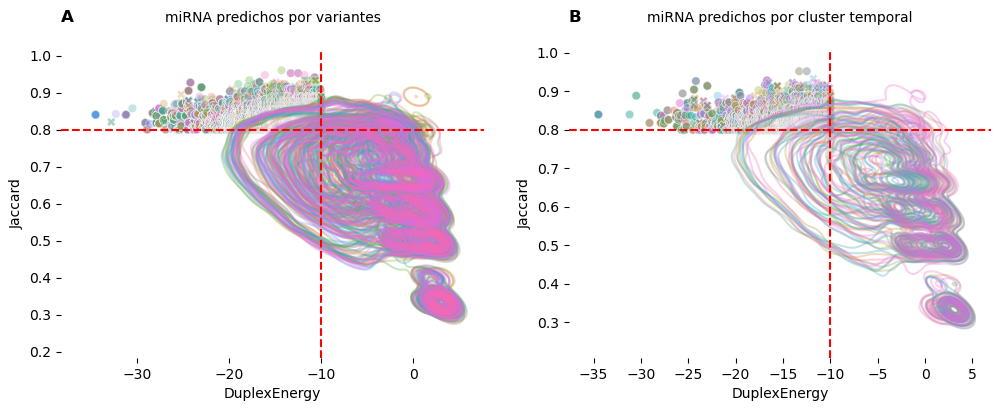

In [76]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2)

markers = {"5'UTR": 'o', "3'UTR": 'X'}

#===================================== First plot on the top =============================
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data=dfv, x = 'DuplexEnergy', y = 'Jaccard', hue = 'Variant', 
                    markers=markers, style = 'Region', alpha = 0.3, ax=ax1, legend = False)
sns.scatterplot(data=dfv[(dfv['DuplexEnergy']<=-10) & (dfv['Jaccard'] >=0.8)], x = 'DuplexEnergy', y = 'Jaccard', hue = 'Variant', 
                markers=markers, style = 'Region', alpha = 0.3, ax=ax1, legend = False)


plt.axvline(x=-10, color='r', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--')


#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("A", fontweight="bold", loc = 'left')
ax1.set_title('miRNA predichos por variantes', fontsize=10, pad=20)



ax2 = fig.add_subplot(gs[0, 1])
sns.kdeplot(data=dft, x = 'DuplexEnergy', y = 'Jaccard', hue = 'Variant', 
                    markers=markers, style = 'Region', alpha = 0.3, ax=ax2, legend = False)
sns.scatterplot(data=dft[(dft['DuplexEnergy']<=-10) & (dft['Jaccard'] >=0.8)], x = 'DuplexEnergy', y = 'Jaccard', hue = 'Variant', 
                markers=markers, style = 'Region', alpha = 0.3, ax=ax2, legend = False)


plt.axvline(x=-10, color='r', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--')


#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("B", fontweight="bold", loc = 'left')
ax2.set_title('miRNA predichos por cluster temporal', fontsize=10, pad=20)


#delete box
sns.despine(left=True, bottom=True)
plt.savefig('../Plots/miRNAPredichos.pdf')

In [93]:
def extract_variant(string):
    return string.split(':')[0].split('>')[1]
dfv['Variant'] = list(map(extract_variant, dfv['UTR_region']))
dfv

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant
0,>Global:31-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"59,83","1,25",-34.5,"i:82,j:1",<-34.60>,0.84,5'UTR,Global
1,>21A:26-192,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"64,88","1,25",-34.5,"i:87,j:1",<-34.60>,0.84,5'UTR,21A
2,>21L:45-218,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,21L
3,>20A:29-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"61,85","1,25",-34.5,"i:84,j:1",<-34.60>,0.84,5'UTR,20A
4,>23F:45-185,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,23F
...,...,...,...,...,...,...,...,...,...,...,...,...
1568959,>19A:17-20,>hsa-miR-3162-3p,".(.&.) 1,3 : 20,21 (4.30) i:2,j:21 <3.80>",.(.&.),"1,3","20,21",4.3,"i:2,j:21",<3.80>,0.40,5'UTR,19A
1568960,>20A:200-203,>hsa-miR-3162-3p,".(.&.) 1,3 : 20,21 (4.30) i:3,j:21 <3.80>",.(.&.),"1,3","20,21",4.3,"i:3,j:21",<3.80>,0.40,5'UTR,20A
1568961,>21A:16-20,>hsa-miR-3162-3p,".(.&.) 2,4 : 20,21 (4.30) i:3,j:21 <3.80>",.(.&.),"2,4","20,21",4.3,"i:3,j:21",<3.80>,0.40,5'UTR,21A
1568962,>20H:17-20,>hsa-miR-3162-3p,".(.&.) 1,3 : 20,21 (4.30) i:2,j:21 <3.80>",.(.&.),"1,3","20,21",4.3,"i:2,j:21",<3.80>,0.40,5'UTR,20H


In [94]:
dfvi = pd.DataFrame(dfv[['Variant', 'Region']].value_counts()).reset_index()
dfvi.groupby(by='Region').agg(['mean', 'std'])

/tmp/ipykernel_12189/2870668426.py:2: FutureWarning: ['Variant'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  dfvi.groupby(by='Region').agg(['mean', 'std'])


0             
                mean          std
Region                           
3'UTR   19662.871795  5194.220306
5'UTR   20566.974359  4747.990220

In [95]:
def extract_region(string):
    return string.split(':')[1]
dfv['RegionMap'] = list(map(extract_region, dfv['UTR_region']))

dfvr = pd.DataFrame(dfv[['RegionMap']].value_counts()).reset_index()
dfvr

,RegionMap,0
0,256-255,103584
1,29696-29695,103584
2,228-234,100928
3,224-223,74368
4,29824-29823,55776
...,...,...
262,29875-29882,2641
263,29875-29884,2641
264,29893-29897,2641
265,29899-29903,2641


In [96]:
dft['Variant'] = list(map(extract_variant, dft['UTR_region']))
dft

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant
0,">(2022-11-01,2023-01-01]:45-209",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2022-11-01,2023-01-01]"
1,">(2022-01-01,2022-06-01]:45-209",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2022-01-01,2022-06-01]"
2,">(2023-07-01,2023-09-06]:45-202",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2023-07-01,2023-09-06]"
3,">(2022-06-01,2022-11-01]:45-202",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2022-06-01,2022-11-01]"
4,">(2021-05-01,2022-01-01]:26-173",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"64,88","1,25",-34.5,"i:87,j:1",<-34.60>,0.84,5'UTR,"(2021-05-01,2022-01-01]"
...,...,...,...,...,...,...,...,...,...,...,...,...
448672,>Global:29888-29887,>hsa-miR-6781-5p,".(.&.) 1,3 : 20,21 (4.00) i:16,j:21 <3.60>",.(.&.),"1,3","20,21",4.0,"i:16,j:21",<3.60>,0.40,3'UTR,Global
448673,">(2022-06-01,2022-11-01]:29871-29903",>hsa-miR-6781-5p,".(.&.) 1,3 : 20,21 (4.00) i:32,j:21 <3.60>",.(.&.),"1,3","20,21",4.0,"i:32,j:21",<3.60>,0.40,3'UTR,"(2022-06-01,2022-11-01]"
448674,">(2023-07-01,2023-09-06]:29871-29903",>hsa-miR-6781-5p,".(.&.) 1,3 : 20,21 (4.00) i:32,j:21 <3.60>",.(.&.),"1,3","20,21",4.0,"i:32,j:21",<3.60>,0.40,3'UTR,"(2023-07-01,2023-09-06]"
448675,>Global:29888-29887,>hsa-miR-5703,".(.&.) 1,3 : 17,18 (4.00) i:16,j:18 <3.60>",.(.&.),"1,3","17,18",4.0,"i:16,j:18",<3.60>,0.40,3'UTR,Global


In [120]:
pd.DataFrame(dft[['Variant', 'Region']].value_counts()).agg(['mean', 'std'])

,0
mean,20394.409091
std,7872.364361


In [117]:
dfti = pd.DataFrame(dft[['Variant', 'Region']].value_counts()).reset_index()
dfti.groupby(by='Region').agg(['mean', 'std'])

/tmp/ipykernel_12189/2832634115.py:2: FutureWarning: ['Variant'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  dfti.groupby(by='Region').agg(['mean', 'std'])


0             
                mean          std
Region                           
3'UTR   23404.090909  9181.992969
5'UTR   17384.727273  5090.054245

In [121]:
dft['RegionMap'] = list(map(extract_region, dft['UTR_region']))

dfvt = pd.DataFrame(dft[['RegionMap']].value_counts()).reset_index()
dfvt

,RegionMap,0
0,29696-29695,29216
1,256-255,29216
2,29824-29823,18592
3,29737-29741,13280
4,29871-29903,13205
...,...,...
90,29871-29875,2641
91,29900-29903,2641
92,29899-29903,2641
93,29893-29897,2641


# Filtro

In [122]:
df_vf = dfv[(dfv['DuplexEnergy']<=-10) & (dfv['Jaccard'] >=0.8)]
df_vf.head()

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant,RegionMap
0,>Global:31-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"59,83","1,25",-34.5,"i:82,j:1",<-34.60>,0.84,5'UTR,Global,31-173
1,>21A:26-192,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"64,88","1,25",-34.5,"i:87,j:1",<-34.60>,0.84,5'UTR,21A,26-192
2,>21L:45-218,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,21L,45-218
3,>20A:29-173,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"61,85","1,25",-34.5,"i:84,j:1",<-34.60>,0.84,5'UTR,20A,29-173
4,>23F:45-185,>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,23F,45-185


In [123]:
df_tf = dft[(dft['DuplexEnergy']<=-10) & (dft['Jaccard'] >=0.8)]
df_tf.head()

,UTR_region,miRNA,Prediction,Interaction,InteractionRegionUTR,InteractionRegionmiRNA,DuplexEnergy,InteractionResidues,MinimumEnergy,Jaccard,Region,Variant,RegionMap
0,">(2022-11-01,2023-01-01]:45-209",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2022-11-01,2023-01-01]",45-209
1,">(2022-01-01,2022-06-01]:45-209",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2022-01-01,2022-06-01]",45-209
2,">(2023-07-01,2023-09-06]:45-202",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2023-07-01,2023-09-06]",45-202
3,">(2022-06-01,2022-11-01]:45-202",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"45,69","1,25",-34.5,"i:68,j:1",<-34.60>,0.84,5'UTR,"(2022-06-01,2022-11-01]",45-202
4,">(2021-05-01,2022-01-01]:26-173",>hsa-miR-638,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,.((((((((((((.((((((.(((.&))).)).)))).))))))))...,"64,88","1,25",-34.5,"i:87,j:1",<-34.60>,0.84,5'UTR,"(2021-05-01,2022-01-01]",26-173


In [124]:
bxv = pd.DataFrame(df_vf[['Variant', 'Region']].value_counts()).reset_index()
bxt = pd.DataFrame(df_tf[['Variant', 'Region']].value_counts()).reset_index()

In [125]:
lst = []
for i in df_vf['miRNA']:
    lst.append(i.split('>')[1])
df_vf['miRNA_lite'] = lst

lst = []
for i in df_tf['miRNA']:
    lst.append(i.split('>')[1])
df_tf['miRNA_lite'] = lst

/tmp/ipykernel_12189/3899041671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vf['miRNA_lite'] = lst
/tmp/ipykernel_12189/3899041671.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf['miRNA_lite'] = lst


In [126]:
df_vf.to_csv('../Data/miRNA_conservedSinEstructuras_Variants_Filter.tsv', sep = '\t', index = False)
df_tf.to_csv('../Data/miRNA_conservedSinEstructuras_Time_Filter.tsv', sep = '\t', index = False)

# Inspeccion

In [128]:
dfvif = pd.DataFrame(df_vf[['Variant', 'Region']].value_counts()).reset_index()
dfvif.groupby(by='Region').agg(['mean', 'std'])

/tmp/ipykernel_12189/904466698.py:2: FutureWarning: ['Variant'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  dftif.groupby(by='Region').agg(['mean', 'std'])


0            
              mean         std
Region                        
3'UTR   409.435897   99.687880
5'UTR   651.282051  114.616741

In [131]:
len(df_tf)

11725

In [130]:
dftif = pd.DataFrame(df_tf[['Variant', 'Region']].value_counts()).reset_index()
dftif.groupby(by='Region').agg(['mean', 'std'])

/tmp/ipykernel_12189/1646039635.py:2: FutureWarning: ['Variant'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  dftif.groupby(by='Region').agg(['mean', 'std'])


0            
              mean         std
Region                        
3'UTR   379.818182   80.537964
5'UTR   686.090909  151.389864

In [104]:
def estadistico(df):
    df5 = df[df['Region'] == "5'UTR"]
    df3 = df[df['Region'] == "3'UTR"]


    shapiro_test5 = stats.shapiro(df5[0])    
    shapiro_test3 = stats.shapiro(df3[0])
    print(f'shapiro wilk{shapiro_test5.pvalue, shapiro_test3.pvalue}')
    if shapiro_test5.pvalue > 0.05 and shapiro_test3.pvalue > 0.05:
        print('t-student')
        test = stats.ttest_ind(df5[0], df3[0])
    else:
        print('mannwhitneu')
        test = stats.mannwhitneyu(df5[0], df3[0])
    return test

In [105]:
estadistico(bxt)

shapiro wilk(0.4455223083496094, 0.9768904447555542)
t-student


TtestResult(statistic=5.923688280836523, pvalue=8.56746278964184e-06, df=20.0)

In [106]:
estadistico(bxv)

shapiro wilk(0.3442733585834503, 0.019390715286135674)
mannwhitneu


MannwhitneyuResult(statistic=1429.0, pvalue=2.4547958115467475e-11)

<Figure size 1100x400 with 0 Axes>

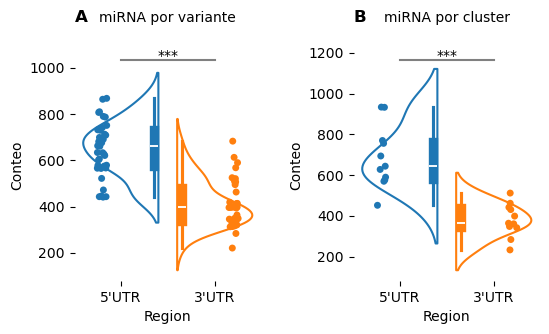

In [116]:
plt.figure(figsize=(11, 4))


fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(1, 2)

#===================================== First plot on the top =============================
#ax1 = fig.add_subplot(gs[0, 0])
#sns.histplot(data=df_vf, x="Variant", kde=True, hue="Region", alpha =0.2, ax=ax1)
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize = 8)
#===================================== Second plot on the top =============================
#ax2 = fig.add_subplot(gs[0, 1])
#sns.histplot(data=df_tf.sort_values(by=['Variant']), x="Variant", kde=True, hue="Region", alpha =0.2, ax=ax2)
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=70, fontsize = 7)
#===================================== Third plot on the top =============================
ax3 = fig.add_subplot(gs[0, 0])
sns.violinplot(data=bxv, x="Region", y=0, hue="Region", fill=False, ax = ax3, split = True)
sns.stripplot(data=bxv, x="Region", y=0, hue="Region", dodge=True, jitter=True, ax=ax3)

# Barra de significancia
y_max = max(bxv[0]) + 100
y_min = min(bxv[0]) + 100
y = y_max + (y_max - y_min) * 0.1  
plt.plot([0, 1], [y, y], color='gray') 
plt.text(0.5, y, "***", ha='center') 

plt.ylabel('Conteo')

plt.title("A", fontweight="bold", loc = 'left')
ax3.set_title('miRNA por variante', fontsize=10, pad=20)
#===================================== Four plot on the top =============================
ax4 = fig.add_subplot(gs[0, 1])
sns.violinplot(data=bxt, x="Region", y=0, hue="Region", fill=False, ax = ax4, split = True)
sns.stripplot(data=bxt, x="Region", y=0, hue="Region", dodge=True, jitter=True, ax=ax4)

# Barra de significancia
y_max = max(bxt[0]) + 160
y_min = min(bxt[0]) + 160
y = y_max + (y_max - y_min) * 0.1  
plt.plot([0, 1], [y, y], color='gray') 
plt.text(0.5, y, "***", ha='center') 

plt.ylabel('Conteo')

plt.title("B", fontweight="bold", loc = 'left')
ax4.set_title('miRNA por cluster', fontsize=10, pad=20)

#delete box
sns.despine(left=True, bottom=True)
plt.subplots_adjust(hspace=1, wspace=0.5)
plt.savefig('../Plots/FilterSummary.pdf', bbox_inches='tight')